# Machine Learning Classifier Models: A Brief Tour I


In this notebook series, we address the following question:

- Given a problem, how do we choose the best ML model and its hyperparameters (these are model parameters that are required to be set for learning patterns from training data)?

More specifically, we emphasize the need for acquiring a scientific understanding of the ML models. The lack of this knowledge limits our ability to use ML for solving practical problems in two ways:

- We don't know how to select the best model
- We don't know how to find optimal hyperparameters of a chosen model

Due to this knowledge gap we resort to the brute-force technique of trying every possible ML models and search over every possible combination of the hyperparameter values. This is not science, and nor is it feasible for solving large and complex problems.

The goal of this notebook series is to convince ourselves **the need for acquiring a scientific understanding of the ML models**, which will lead towards the knowledge of the science of optimal training of the models.



In this notebook, we will explore 10 Machine Learning (ML) classifier models:
1. K-Nearest Neighbors (KNN)
2. Logistic Regression
3. Polynomial Logistic Regression
4. Naive Bayes
5. Linear Support Vector Machine (Linear SVM)
6. Non-Linear Support Vector Machine (SVM Gaussian Radial Basis Function)
7. Decision Tree
8. Ensemble Method: Random Forest
9. Ensemble Method: Voting Clasifier
10. Multi-Layer Perceptron (MLP)


We will use the Scikit-Learn implementations of these models and compare their performance on a two-dimensional and non-linear synthetic dataset. The models will be used to solve a **binary classification problem**.

We will split the dataset (randomly) into training and test subsets, then train each model using the training data subset. Finally, we will evaluate a model's performance on the unseen test data subset.

The performance of each model depends of a set of hyperparameters. The standard practice in ML is to first find the optimal hyperparameters by searching over a range of values for the hyperparameters. This technique is known as hyperparameter tuning. Unless the optimal hyperparameter values are selected in training a model, it will not perform optimally. 

In this notebook, we will not search optimal hyperparameters. In most of the cases, we will use the Scikit-Learn default setting of the hyperparameters. However, we may vary only a few key hyperparameters to show how they influence the model's performance on test data.

We will see that most of the models are very sensitive to the choice of hyperparameter values. Thus, it is imperative to learn how to choose hyperparameters optimally. Also not all models are equally effective for a given dataset. A deep knowledge on the models is essential for finding the best model.


## Takeaway Lesson

There are at least two takeway lessons:

1. The problem (dataset) should dictate the choice of models. It's never a good idea to search over every possible model.

2.  While an informed hyperparameter tuning is useful for smaller datasets, a blind and brute-force search over the hyperparamter space is never a good idea, because:

      -- It's not science.
      
      -- It's not feasible for complex models such as MLP that uses very large dataset.


Thus, after reviewing this notebook we should be able to convince ourselves about **the need for acquiring a scientic understanding of these ML models**, which will lead towards the knowledge of the science of optimal training of the models.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_circles

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline

# Synthetic 2D Dataset

We will use Scikit-Learn's "datasets.make_circles" function to generate a synthetic non-linear dataset that is suitable for investigating classification (as well as clustering) models. It creates a large circle containing a smaller circle in 2d.

The following two parameters are used by the make_circles function:

- factor : Scale factor between inner and outer circle. Range 0 ~ 1.

- noise : Standard deviation of Gaussian noise added to the data.

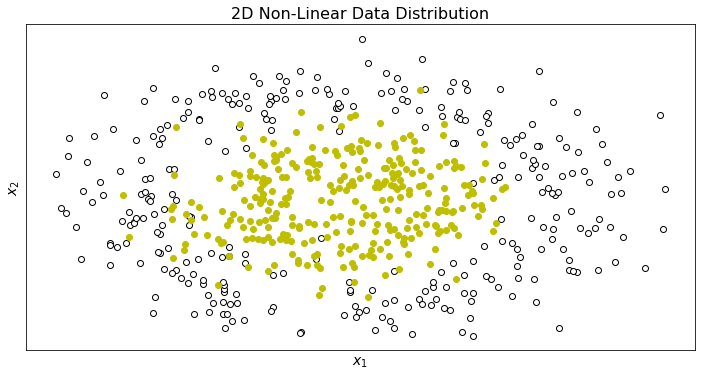

In [2]:
X, y = make_circles(600, factor=0.4, noise=0.20)

plt.figure(figsize=(12, 6))
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "wo", markeredgecolor="k")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")

plt.title("2D Non-Linear Data Distribution", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.xticks(())
plt.yticks(())
plt.show()

## Create Training and Test Dataset

In [3]:
# Spilt the dataset into training and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(480, 2)
(120, 2)
(480,)
(120,)


# Function for Plotting Decision Bounday 


To better understand how a model performs classifiation, we need to **<font color=red size=6> visualize </font>** its decision boundary.

We define the function "decision_boundary_class_colored" to plot the decision boundary. 

In [4]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 0.1, X[:, 0].max() + 0.1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 0.1, X[:, 1].max() + 0.1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.RdGy, alpha=0.99)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()    

## K-Nearest Neighbors

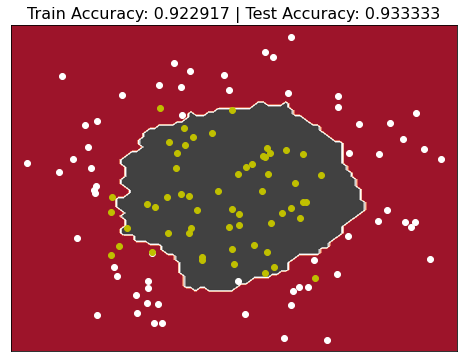

In [5]:
# Create the model
knn = KNeighborsClassifier(n_neighbors=10)
    
# Fit the model
knn.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy_knn = knn.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy_knn = knn.score(X_test, y_test) 

plt.figure(figsize=(8,6))
decision_boundary_class_colored(knn, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Train Accuracy: %f | Test Accuracy: %f"% 
          (train_accuracy_knn, test_accuracy_knn) , fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

## Logistic Regression

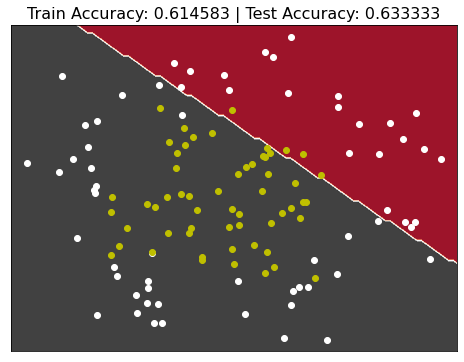

In [6]:
# Create the model
lg_reg = LogisticRegression()
    
# Fit the model
lg_reg.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy_lg_reg = lg_reg.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy_lg_reg = lg_reg.score(X_test, y_test) 

plt.figure(figsize=(8,6))

decision_boundary_class_colored(lg_reg, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Train Accuracy: %f | Test Accuracy: %f"% 
          (train_accuracy_lg_reg, test_accuracy_lg_reg) , fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

## Polynomial Logistic Regression

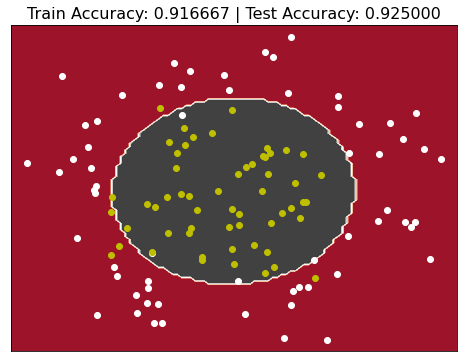

In [7]:
optimal_poly_degree = 2

# Create the model
lg_reg_poly = Pipeline([
    ("poly_features", PolynomialFeatures(degree=optimal_poly_degree)), # Add polynomial terms with the feature vector
    ("scaler", StandardScaler()), # Scale the features
    ("clf", LogisticRegression())
    ])

# Fit the model
lg_reg_poly.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy_lg_reg_poly = lg_reg_poly.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy_lg_reg_poly = lg_reg_poly.score(X_test, y_test) 

plt.figure(figsize=(8,6))

decision_boundary_class_colored(lg_reg_poly, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Train Accuracy: %f | Test Accuracy: %f"% 
          (train_accuracy_lg_reg_poly, test_accuracy_lg_reg_poly) , fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

## Naive Bayes Classifier

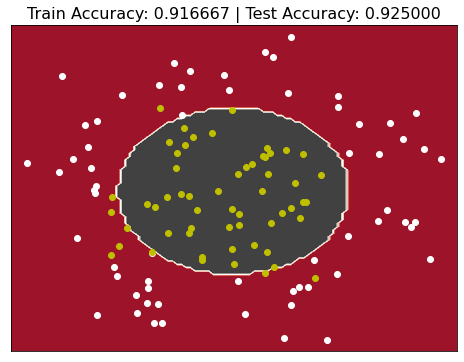

In [8]:
# Create the model
nb = GaussianNB()

# Fit the model
nb.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy_nb = nb.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy_nb = nb.score(X_test, y_test) 

plt.figure(figsize=(8,6))

decision_boundary_class_colored(nb, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Train Accuracy: %f | Test Accuracy: %f"% 
          (train_accuracy_nb, test_accuracy_nb) , fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

## Support Vector Machine (Linear)

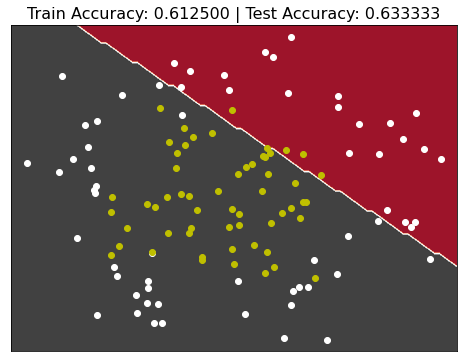

In [9]:
# Create the model: Linear SVM
svm_linear = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC()),
    ])

# Fit the model
svm_linear.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy_svm_linear = svm_linear.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy_svm_linear = svm_linear.score(X_test, y_test) 

plt.figure(figsize=(8,6))

decision_boundary_class_colored(svm_linear, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Train Accuracy: %f | Test Accuracy: %f"% 
          (train_accuracy_svm_linear, test_accuracy_svm_linear) , fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

## Non-Linear Support Vector Machine (Gaussian Radial Basis Function)

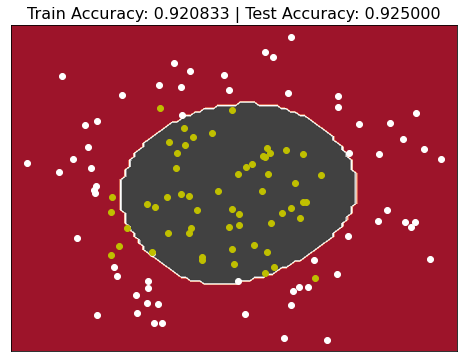

In [10]:
# Create the model: Gaussian Radial Basis Function (RBF) based SVM
svm = SVC(kernel="rbf", gamma=1.0, C=10)

# Fit the model
svm.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy_svm = svm.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy_svm = svm.score(X_test, y_test) 

plt.figure(figsize=(8,6))

decision_boundary_class_colored(svm, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Train Accuracy: %f | Test Accuracy: %f"% 
          (train_accuracy_svm, test_accuracy_svm) , fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

## Decision Tree

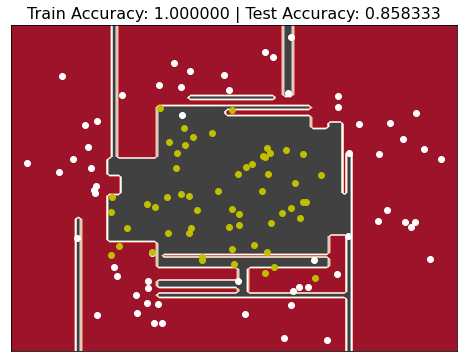

In [11]:
# Create the model
dtree = DecisionTreeClassifier(max_depth=30)
    
# Fit the model
dtree.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy_dtree = dtree.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy_dtree = dtree.score(X_test, y_test) 

plt.figure(figsize=(8,6))

decision_boundary_class_colored(dtree, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Train Accuracy: %f | Test Accuracy: %f"% 
          (train_accuracy_dtree, test_accuracy_dtree) , fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

## Ensemble Mathod: Random Forest

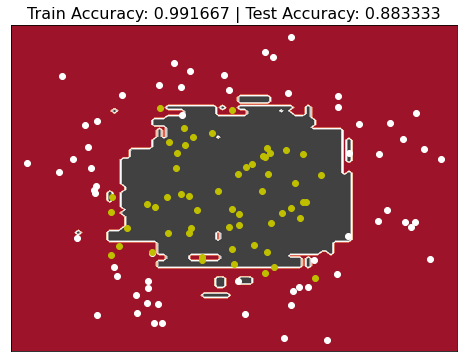

In [12]:
# Create the model
rndforest = RandomForestClassifier(n_estimators=10, max_depth=20)
    
# Fit the model
rndforest.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy_rndforest = rndforest.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy_rndforest = rndforest.score(X_test, y_test) 

plt.figure(figsize=(8,6))

decision_boundary_class_colored(rndforest, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Train Accuracy: %f | Test Accuracy: %f"% 
          (train_accuracy_rndforest, test_accuracy_rndforest) , fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

## Ensemble Method: Voting Classifier

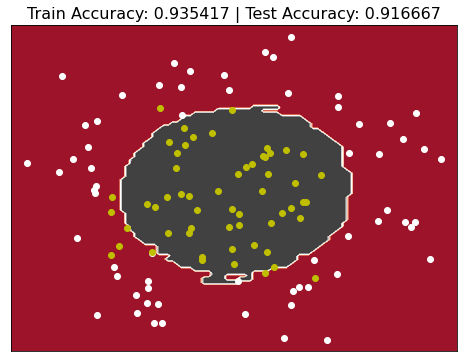

In [13]:
# Create the model
voting_clf = VotingClassifier(
    estimators=[('K-NN', knn), 
                ('Naive Bayes', nb), 
                ('Support Vector Machine', svm), 
                ('Random Forest', rndforest)],
    voting='hard')

# Fit the model
voting_clf.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy_voting_clf = voting_clf.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy_voting_clf = voting_clf.score(X_test, y_test) 

plt.figure(figsize=(8,6))

decision_boundary_class_colored(voting_clf, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Train Accuracy: %f | Test Accuracy: %f"% 
          (train_accuracy_voting_clf, test_accuracy_voting_clf) , fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

## Artificial Neural Network (Multi-Layer Perceptron)


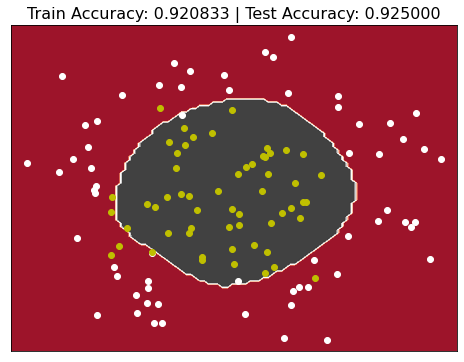

In [14]:
# Create the model
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("MLP", MLPClassifier(hidden_layer_sizes=(10,), alpha=0.1, 
                              activation='logistic', solver='lbfgs',
                              early_stopping=True, n_iter_no_change=5,
                      max_iter=1000)),
    ])
    
# Fit the model
mlp.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy_mlp = mlp.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy_mlp = mlp.score(X_test, y_test) 

plt.figure(figsize=(8,6))

decision_boundary_class_colored(mlp, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Train Accuracy: %f | Test Accuracy: %f"% 
          (train_accuracy_mlp, test_accuracy_mlp) , fontsize=16)
plt.xticks(())
plt.yticks(())
plt.show()

## Performance Comparison of 10 Models

In [15]:
data = [
    ["KNN", train_accuracy_knn, test_accuracy_knn],
    ["Logistic Regression", train_accuracy_lg_reg, test_accuracy_lg_reg],
    ["Polynomial Logistic Regression", train_accuracy_lg_reg_poly, test_accuracy_lg_reg_poly],
    ["Naive Bayes", train_accuracy_nb, test_accuracy_nb],
    ["Support Vector Machine (Linear)", train_accuracy_svm_linear, test_accuracy_svm_linear],
    ["Support Vector Machine (Gaussian RBF)", train_accuracy_svm, test_accuracy_svm],
    ["Decision Tree", train_accuracy_dtree, test_accuracy_dtree],
    ["Ensemble: Random Forest", train_accuracy_rndforest, test_accuracy_rndforest],
    ["Ensemble: Voting Classifier", train_accuracy_voting_clf, test_accuracy_voting_clf],
    ["Multi-Layer Perceptron", train_accuracy_mlp, test_accuracy_mlp],
    
    ]
pd.DataFrame(data, columns=["Model", "Train Accuracy", "Test Accuracy"])

,Model,Train Accuracy,Test Accuracy
0,KNN,0.922917,0.933333
1,Logistic Regression,0.614583,0.633333
2,Polynomial Logistic Regression,0.916667,0.925000
3,Naive Bayes,0.916667,0.925000
4,Support Vector Machine (Linear),0.612500,0.633333
5,Support Vector Machine (Gaussian RBF),0.920833,0.925000
6,Decision Tree,1.000000,0.858333
7,Ensemble: Random Forest,0.991667,0.883333
8,Ensemble: Voting Classifier,0.935417,0.916667
9,Multi-Layer Perceptron,0.920833,0.925000


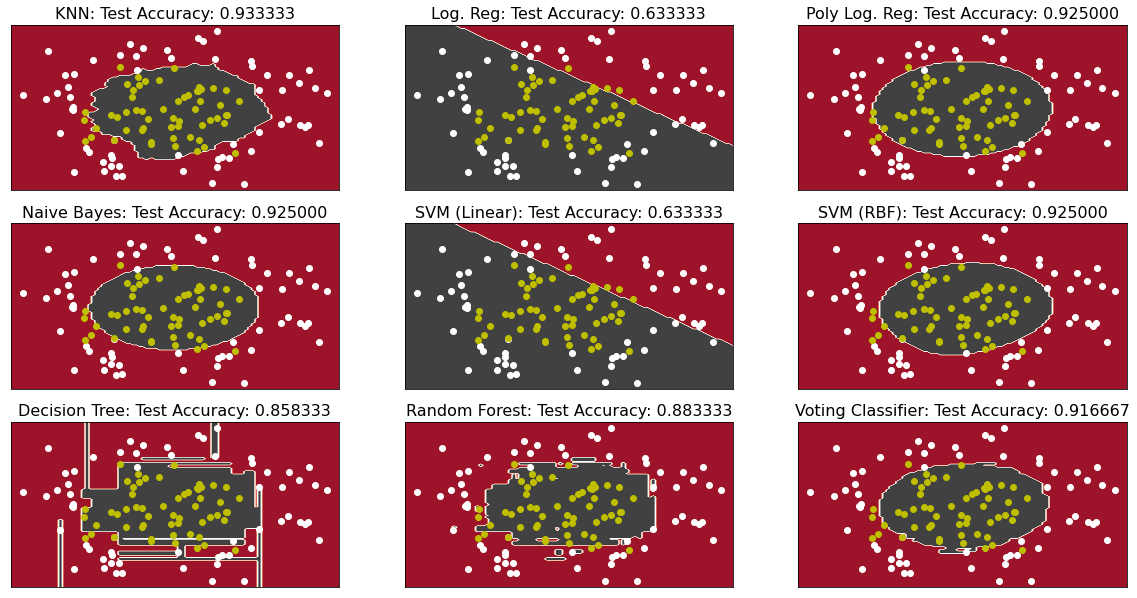

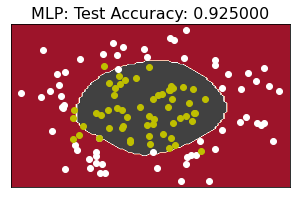

In [16]:
plt.figure(figsize=(20,14))

plt.subplot(431)
decision_boundary_class_colored(knn, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("KNN: Test Accuracy: %f"% 
          (test_accuracy_knn) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(432)
decision_boundary_class_colored(lg_reg, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Log. Reg: Test Accuracy: %f"% 
          (test_accuracy_lg_reg) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(433)
decision_boundary_class_colored(lg_reg_poly, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Poly Log. Reg: Test Accuracy: %f"% 
          (test_accuracy_lg_reg_poly) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(434)
decision_boundary_class_colored(nb, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Naive Bayes: Test Accuracy: %f"% 
          (test_accuracy_nb) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(435)
decision_boundary_class_colored(svm_linear, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("SVM (Linear): Test Accuracy: %f"% 
          (test_accuracy_svm_linear) , fontsize=16)
plt.xticks(())
plt.yticks(())



plt.subplot(436)
decision_boundary_class_colored(svm, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("SVM (RBF): Test Accuracy: %f"% 
          (test_accuracy_svm) , fontsize=16)
plt.xticks(())
plt.yticks(())



plt.subplot(437)
decision_boundary_class_colored(dtree, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Decision Tree: Test Accuracy: %f"% 
          (test_accuracy_dtree) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(438)
decision_boundary_class_colored(rndforest, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Random Forest: Test Accuracy: %f"% 
          (test_accuracy_rndforest) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(439)
decision_boundary_class_colored(voting_clf, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("Voting Classifier: Test Accuracy: %f"% 
          (test_accuracy_voting_clf) , fontsize=16)
plt.xticks(())
plt.yticks(())

plt.show()

plt.figure(figsize=(5,3))
decision_boundary_class_colored(mlp, X_test, plotDistanceFromHyperplane=False)
plt.plot(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], "wo")
plt.plot(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], "yo")
plt.title("MLP: Test Accuracy: %f"% 
          (test_accuracy_mlp) , fontsize=16)
plt.xticks(())
plt.yticks(())

plt.show()